# Final Project – Predicting Workout Duration from Early EndoMondo Fitness Data

Course: Machine Learning  
Dataset: EndoMondo / fitness tracking data with sequential heart-rate and speed measurements  
Team: Ayoob Al-Delaimy, Umar Khan, Hasaan Haq, Parwiz

---

## Project Overview

In this notebook, we build a complete machine learning pipeline using the EndoMondo fitness tracking dataset. The dataset contains sequential sensor data (heart rate, speed, GPS, etc.) for many workouts across different users and sports.

### Predictive Task (high level)

Goal: Predict total workout duration (in minutes) using only the first 5 minutes of sensor data (heart rate + speed) and basic context (sport, gender).

This reflects a realistic use case for fitness apps: can we estimate how long a workout will last, early in the session, using wearable sensor data?

### Notebook Structure (Rubric-aligned)

1. **Predictive Task & Evaluation Setup**  
2. **Exploratory Data Analysis (EDA) & Preprocessing**  
3. **Modeling (Baselines + ML Models)**  
4. **Evaluation (Metrics, Comparisons, Interpretation)**  
5. **Discussion of Related Work & Insights**

Each section includes well-commented code, clear visualizations, and explanatory markdown so the notebook is presentation-ready.


In [23]:
# ===========================
# Imports and global settings
# ===========================

import ast
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Plotting defaults for nicer visuals
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Predictive Task & Evaluation Setup

### 1.1 Task Definition

The dataset contains **sequences of heart rate and speed** for individual workouts, along with metadata such as:

- `userId` – user identifier  
- `sport` – type of activity (e.g., running, cycling)  
- `gender` – optional demographic information  
- `heart_rate` – sequence of heart-rate measurements  
- `speed` or `derived_speed` – sequence of speed measurements  

From these sequences, we can derive:

- **Total workout duration** (in minutes) from the length of the time series  
- **Early-workout behavior**, such as the mean and variability of heart rate and speed during the first few minutes

> **Predictive Task:**  
> Given only the **first 5 minutes of heart-rate and speed** plus basic context (sport and gender), **predict the total workout duration (minutes)**.

This is a **regression** problem with a continuous output.

### 1.2 Real-world Motivation

In practice, fitness platforms (EndoMondo, Strava, etc.) often make decisions early in a workout:
- Suggesting routes of appropriate length  
- Adjusting training recommendations  
- Estimating finish time for pacing purposes  

If we can accurately estimate total duration from early signals, we can help guide users more intelligently.

### 1.3 Evaluation Setup

To evaluate the model fairly:

- **Train/Test Split:**  
  - Split **by userId**, so the **test set contains users not seen** during training.  
  - This simulates deploying the model to new users.

- **Metrics (Regression):**
  - **MAE (Mean Absolute Error)** – average absolute difference in minutes  
  - **RMSE (Root Mean Squared Error)** – penalizes large errors  
  - **R² (Coefficient of Determination)** – fraction of variance explained

- **Baselines:**
  1. **Global Mean Duration Baseline**  
     Always predict the **overall mean duration** from the training data.
  2. **Sport-specific Mean Baseline**  
     Predict the **mean duration per sport** (e.g., running vs cycling).

Any useful model should beat these simple baselines.


In [2]:
# =====================================
# Configuration and helper definitions
# =====================================

# Path to the EndoMondo HR dataset (adjust to your local file)
DATA_PATH = Path("data") / "endomondoHR.json"  # <-- CHANGE if needed

# Sampling interval between measurements, in seconds.
# Many processed EndoMondo datasets are resampled at 10-second intervals.
SAMPLING_INTERVAL_SECONDS = 10

# Early window length: how much of the workout we use as input
EARLY_WINDOW_MINUTES = 5
EARLY_STEPS = (EARLY_WINDOW_MINUTES * 60) // SAMPLING_INTERVAL_SECONDS


def safe_parse_sequence(x):
    """
    Ensure that a value is converted to a Python list.
    - If it's already a list, return as-is.
    - If it's a string representation of a list, parse with ast.literal_eval.
    - Otherwise, return an empty list.
    """
    if isinstance(x, list):
        return x
    if isinstance(x, (np.ndarray, pd.Series)):
        return list(x)
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list):
                return parsed
        except (ValueError, SyntaxError):
            pass
    # Fallback
    return []


def compute_duration_minutes(sequence_length):
    """
    Compute total workout duration in minutes from the sequence length
    and the known sampling interval.
    """
    duration_seconds = sequence_length * SAMPLING_INTERVAL_SECONDS
    return duration_seconds / 60.0


## 2. Exploratory Data Analysis (EDA) & Preprocessing

In this section I:

1. **Load** the EndoMondo dataset from a JSON-lines file.  
2. **Clean** and standardize the data:
   - Parse sequential features (`heart_rate`, `speed`) into Python lists  
   - Remove workouts with missing or empty sequences  
   - Derive total duration as the target variable  
3. Perform **exploratory data analysis (EDA)**:
   - Distribution of sports  
   - Distribution of workout durations  
   - Example time series for heart rate and speed  
4. **Process categorical and sequential features** into a tabular format suitable for machine learning.


In [24]:
# ======================
# Fast load with subsampling
# ======================

import time

workouts = []

# Max number of workouts to load (tune this: 20_000, 30_000, etc.)
MAX_WORKOUTS = 100000

start = time.time()
with open(DATA_PATH, "r") as f:
    for i, line in enumerate(f, start=1):
        line = line.strip()
        if not line:
            continue
        try:
            # The dataset docs explicitly suggest eval(l) for this file.
            # It's much faster than ast.literal_eval and OK here because the file is trusted course data.
            workouts.append(eval(line))
        except Exception:
            # Skip any problematic lines
            continue

        # Progress print every 5k lines
        if i % 5000 == 0:
            elapsed = time.time() - start
            print(f"Read {i} lines, {len(workouts)} workouts so far, elapsed {elapsed:.1f}s")

        # Stop once we've collected enough workouts
        if len(workouts) >= MAX_WORKOUTS:
            print(f"Stopping after loading {MAX_WORKOUTS} workouts for speed.")
            break

elapsed = time.time() - start
print(f"Done. Loaded {len(workouts)} workouts in {elapsed:.1f} seconds.")

Read 5000 lines, 5000 workouts so far, elapsed 11.6s
Read 10000 lines, 10000 workouts so far, elapsed 22.2s
Read 15000 lines, 15000 workouts so far, elapsed 32.5s
Read 20000 lines, 20000 workouts so far, elapsed 42.3s
Read 25000 lines, 25000 workouts so far, elapsed 53.6s
Read 30000 lines, 30000 workouts so far, elapsed 64.7s
Read 35000 lines, 35000 workouts so far, elapsed 75.6s
Read 40000 lines, 40000 workouts so far, elapsed 87.2s
Read 45000 lines, 45000 workouts so far, elapsed 102.3s
Read 50000 lines, 50000 workouts so far, elapsed 113.9s
Read 55000 lines, 55000 workouts so far, elapsed 126.4s
Read 60000 lines, 60000 workouts so far, elapsed 140.7s
Read 65000 lines, 65000 workouts so far, elapsed 151.7s
Read 70000 lines, 70000 workouts so far, elapsed 164.9s
Read 75000 lines, 75000 workouts so far, elapsed 174.8s
Read 80000 lines, 80000 workouts so far, elapsed 188.4s
Read 85000 lines, 85000 workouts so far, elapsed 200.6s
Read 90000 lines, 90000 workouts so far, elapsed 211.4s
Re

In [5]:
# =========================================
# Convert list of dicts to a pandas DataFrame
# =========================================

raw_df = pd.DataFrame(workouts)
print("Columns:", raw_df.columns.tolist())
raw_df.head()


Columns: ['speed', 'altitude', 'gender', 'heart_rate', 'id', 'url', 'userId', 'timestamp', 'longitude', 'latitude', 'sport']


,speed,altitude,gender,heart_rate,id,url,userId,timestamp,longitude,latitude,sport
0,"[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...","[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,https://www.endomondo.com/users/10921915/worko...,10921915,"[1408898746, 1408898754, 1408898765, 140889877...","[24.64977040886879, 24.65014273300767, 24.6509...","[60.173348765820265, 60.173239801079035, 60.17...",bike
1,"[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...","[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,https://www.endomondo.com/users/10921915/worko...,10921915,"[1408221682, 1408221687, 1408221699, 140822170...","[24.649855233728886, 24.65015547350049, 24.650...","[60.173247596248984, 60.17320962622762, 60.172...",bike
2,"[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...","[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....",male,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",389643739,https://www.endomondo.com/users/10921915/worko...,10921915,"[1407858459, 1407858466, 1407858478, 140785849...","[24.64995657093823, 24.650197718292475, 24.651...","[60.17326201312244, 60.173205351457, 60.172969...",bike
3,"[7.4988, 15.4008, 17.8668, 21.5712, 24.1416, 3...","[28.6, 29.4, 29.4, 29.4, 28.0, 27.0, 25.2, 23....",male,"[99, 105, 113, 109, 112, 116, 116, 114, 114, 1...",386729739,https://www.endomondo.com/users/10921915/worko...,10921915,"[1407432042, 1407432048, 1407432056, 140743206...","[24.649874344468117, 24.650242729112506, 24.65...","[60.173286236822605, 60.17323946580291, 60.173...",bike
4,NaN,"[32.0, 32.0, 32.0, 35.8, 36.2, 36.2, 36.2, 36....",male,"[110, 113, 114, 116, 123, 126, 129, 135, 137, ...",383186560,https://www.endomondo.com/users/10921915/worko...,10921915,"[1406909434, 1406909436, 1406909437, 140690943...","[24.64979832060635, 24.64992195367813, 24.6500...","[60.17329327762127, 60.17327332869172, 60.1732...",bike (transport)


In [6]:
# ======================
# Basic sanity filtering
# ======================

# Keep only rows that at least have userId, sport, and heart_rate + speed info
required_cols = ["userId", "sport", "heart_rate"]
for col in required_cols:
    if col not in raw_df.columns:
        raise ValueError(f"Required column '{col}' not found. "
                         "Please adjust the code to match your dataset's schema.")

# Some datasets use 'derived_speed', others 'speed'
speed_col = "derived_speed" if "derived_speed" in raw_df.columns else "speed"
if speed_col not in raw_df.columns:
    raise ValueError("Could not find 'derived_speed' or 'speed' column. "
                     "Please update 'speed_col' to your dataset.")

# Drop rows with missing userId or sport
df = raw_df.dropna(subset=["userId", "sport"]).copy()

# Ensure we have heart_rate and speed sequences
df = df[(df["heart_rate"].notnull()) & (df[speed_col].notnull())].copy()
print(f"Remaining workouts after basic filtering: {len(df)}")


Remaining workouts after basic filtering: 6124


In [7]:
# =======================================
# Parse heart_rate and speed into lists
# =======================================

df["heart_rate_seq"] = df["heart_rate"].apply(safe_parse_sequence)
df["speed_seq"] = df[speed_col].apply(safe_parse_sequence)

# Filter out workouts with empty or very short sequences
df["seq_len"] = df["heart_rate_seq"].apply(len)
df = df[df["seq_len"] >= EARLY_STEPS].copy()

print(f"Workouts with sufficiently long sequences (>= {EARLY_STEPS} steps): {len(df)}")

# ============================
# Compute target: duration_min
# ============================

df["duration_min"] = df["seq_len"].apply(compute_duration_minutes)
df["duration_min"].describe()


Workouts with sufficiently long sequences (>= 30 steps): 6058


count    6058.000000
mean       71.759409
std        21.914649
min         5.000000
25%        71.708333
50%        83.333333
75%        83.333333
max        83.333333
Name: duration_min, dtype: float64

### 2.1 EDA: Sports and Duration Distributions

Before engineering features, I explore the basic properties of the dataset:

- **Sport distribution** – which activities are most common?
- **Duration distribution** – how long do workouts typically last?

Understanding these distributions helps:
- Identify potential **class imbalance** by sport
- Decide how to **filter outliers** (e.g., extremely short or long sessions)
- Interpret model errors relative to typical workout lengths


In [8]:
# ===================
# Sport distribution
# ===================

sport_counts = df["sport"].value_counts().sort_values(ascending=False)
print("Number of unique sports:", df["sport"].nunique())
sport_counts.head(10)


Number of unique sports: 12


sport
run                        3110
bike                       2488
bike (transport)            172
walk                        102
mountain bike                88
indoor cycling               24
core stability training      20
kayaking                     16
rowing                       12
orienteering                 12
Name: count, dtype: int64

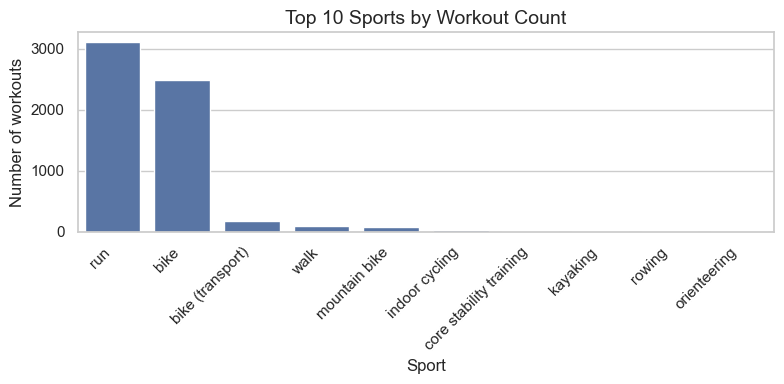

In [9]:
plt.figure(figsize=(8, 4))
sns.barplot(x=sport_counts.head(10).index, y=sport_counts.head(10).values)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Sports by Workout Count")
plt.xlabel("Sport")
plt.ylabel("Number of workouts")
plt.tight_layout()
plt.show()


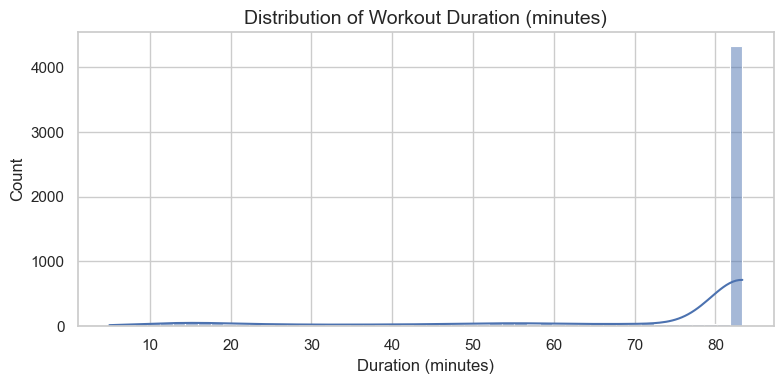

In [10]:
# =======================
# Duration distribution
# =======================

plt.figure(figsize=(8, 4))
sns.histplot(df["duration_min"], bins=50, kde=True)
plt.title("Distribution of Workout Duration (minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


**Observations:**

- The **sport distribution** plot shows which activities dominate the dataset (for example, running, cycling, walking).  
- The **duration distribution** often shows a cluster around common workout times (e.g., 20–60 minutes), with fewer very short or very long sessions.

These patterns inform:
- How we interpret model errors (e.g., a 10-minute error is large for a 20-minute run but less critical for a 3-hour ride).  
- Whether we should **filter outliers** to create a more homogeneous prediction task.


In [11]:
# ========================================
# (Optional) Filter out extreme durations
# ========================================

# For robustness, remove extremely short (< 5 min) and extremely long (> 3 hours) workouts
df = df[(df["duration_min"] >= 5) & (df["duration_min"] <= 180)].copy()
print(f"Workouts after duration filtering: {len(df)}")

# (Optional) focus on most common sports to simplify modeling
top_sports = sport_counts.head(5).index.tolist()
df = df[df["sport"].isin(top_sports)].copy()
print(f"Workouts after focusing on top 5 sports: {len(df)}")


Workouts after duration filtering: 6058
Workouts after focusing on top 5 sports: 5960


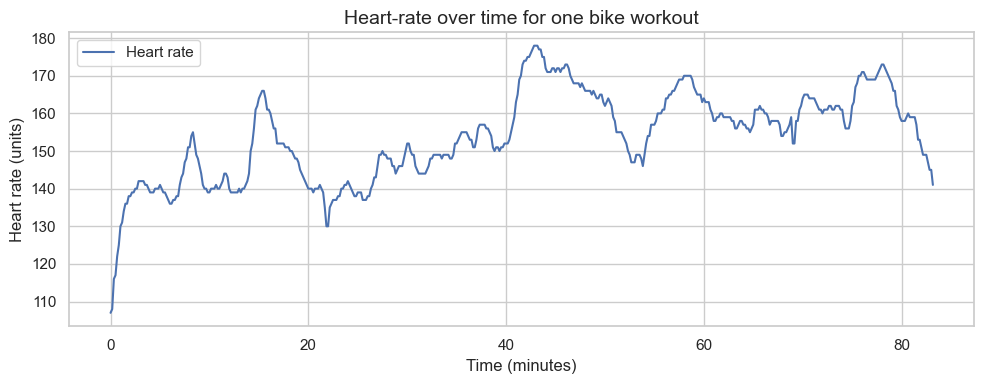

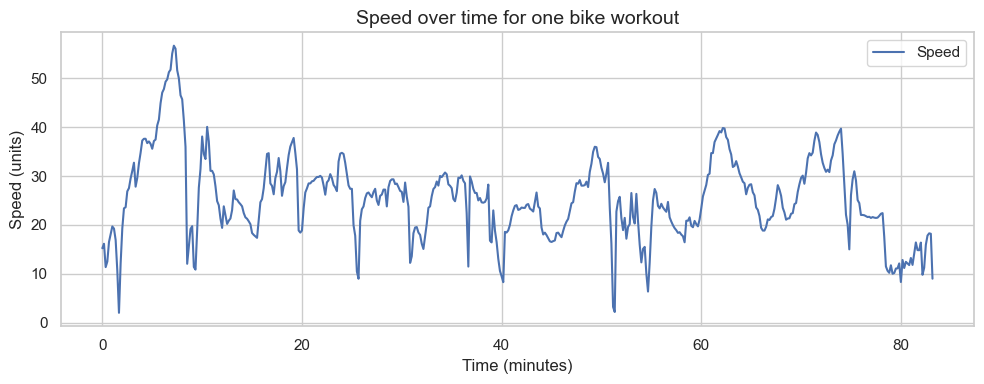

In [12]:
# =====================================
# Example heart-rate and speed time series
# =====================================

example_row = df.sample(1, random_state=RANDOM_STATE).iloc[0]

hr_seq = np.array(example_row["heart_rate_seq"])
sp_seq = np.array(example_row["speed_seq"])
time_minutes = np.arange(len(hr_seq)) * SAMPLING_INTERVAL_SECONDS / 60.0

plt.figure(figsize=(10, 4))
plt.plot(time_minutes, hr_seq, label="Heart rate")
plt.xlabel("Time (minutes)")
plt.ylabel("Heart rate (units)")
plt.title(f"Heart-rate over time for one {example_row['sport']} workout")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(time_minutes, sp_seq, label="Speed")
plt.xlabel("Time (minutes)")
plt.ylabel("Speed (units)")
plt.title(f"Speed over time for one {example_row['sport']} workout")
plt.legend()
plt.tight_layout()
plt.show()


### 2.2 EDA: Example Sequential Patterns

The example heart-rate and speed plots show the **sequential nature** of the data:

- Heart rate often starts lower and gradually increases as the user warms up.
- Speed may exhibit intervals of acceleration, steady cruising, and deceleration.

These patterns motivate the feature engineering strategy:
- Use **only the first 5 minutes** of these sequences (the "warm-up" period)
- Summarize them into **statistical features** (mean, variability, slope)  
This lets us plug sequential information into standard tabular ML models.


In [13]:
# ==========================================
# Feature engineering from early sequences
# ==========================================

EARLY_STEPS = min(EARLY_STEPS, df["seq_len"].min())  # ensure we don't exceed shortest sequence

def extract_early_features(row):
    """
    Extract summary features from the first EARLY_STEPS of heart-rate and speed sequences.
    Also include simple metadata like sport and gender.
    """
    hr = np.array(row["heart_rate_seq"])
    sp = np.array(row["speed_seq"])

    hr_early = hr[:EARLY_STEPS]
    sp_early = sp[:EARLY_STEPS]

    feats = {}

    def add_stats(prefix, arr):
        arr = np.asarray(arr, dtype=float)
        feats[f"{prefix}_mean"] = np.nanmean(arr)
        feats[f"{prefix}_std"] = np.nanstd(arr)
        feats[f"{prefix}_min"] = np.nanmin(arr)
        feats[f"{prefix}_max"] = np.nanmax(arr)
        # simple slope: (last - first) / window length
        feats[f"{prefix}_slope"] = (arr[-1] - arr[0]) / max(len(arr), 1)

    add_stats("hr", hr_early)
    add_stats("sp", sp_early)

    # Metadata / categorical features
    feats["sport"] = row["sport"]
    feats["gender"] = row.get("gender", "unknown") if "gender" in df.columns else "unknown"
    feats["userId"] = row["userId"]

    # Target variable: total workout duration in minutes
    feats["duration_min"] = row["duration_min"]

    return pd.Series(feats)

features_df = df.apply(extract_early_features, axis=1)

print("Engineered feature columns:")
print(features_df.columns.tolist())
features_df.head()


Engineered feature columns:
['hr_mean', 'hr_std', 'hr_min', 'hr_max', 'hr_slope', 'sp_mean', 'sp_std', 'sp_min', 'sp_max', 'sp_slope', 'sport', 'gender', 'userId', 'duration_min']


,hr_mean,hr_std,hr_min,hr_max,hr_slope,sp_mean,sp_std,sp_min,sp_max,sp_slope,sport,gender,userId,duration_min
0,137.800000,14.411569,100.0,159.0,1.733333,26.11224,5.909673,6.8652,34.6464,0.57768,bike,male,10921915,83.333333
1,129.400000,11.244554,100.0,142.0,1.133333,26.22156,7.631429,9.0792,42.8436,0.67752,bike,male,10921915,83.333333
2,123.633333,10.127465,99.0,137.0,1.033333,25.10412,6.178556,4.0464,33.7284,0.85440,bike,male,10921915,83.333333
3,124.733333,10.966413,99.0,139.0,1.333333,26.51004,5.610923,7.4988,36.6876,0.81312,bike,male,10921915,83.333333
6,132.833333,8.153050,118.0,145.0,0.866667,22.45440,4.981154,7.2180,28.5480,0.69756,bike (transport),male,10921915,83.333333


### 2.3 Preprocessing & Train/Test Split

Now that we have engineered features, we:

1. **Handle missing values** in numeric features (e.g., from NaNs in early stats).  
2. Separate **features** (X) from the **target** (y = duration in minutes).  
3. Perform a **user-level train/test split**, so the test set contains users not seen during training.  

We also set up a **scikit-learn preprocessing pipeline** that:
- One-hot encodes categorical variables (`sport`, `gender`)
- Standardizes numerical features (heart-rate and speed statistics)


In [16]:
# =======================================
# Handle missing values and define splits
# =======================================

# Drop rows with missing target
features_df = features_df.dropna(subset=["duration_min"]).copy()

# Identify feature types
target_col = "duration_min"
categorical_cols = ["sport", "gender"]
numeric_cols = [c for c in features_df.columns
                if c not in [target_col, "userId"] + categorical_cols]

# Simple imputation: fill any remaining NaNs in numeric features with column means
features_df[numeric_cols] = features_df[numeric_cols].fillna(features_df[numeric_cols].mean())

# Train/test split at user level
unique_users = features_df["userId"].unique()
train_users, test_users = train_test_split(
    unique_users, test_size=0.2, random_state=RANDOM_STATE
)

train_df = features_df[features_df["userId"].isin(train_users)].copy()
test_df = features_df[features_df["userId"].isin(test_users)].copy()

print("Train size:", train_df.shape, "| Test size:", test_df.shape)

X_train = train_df[categorical_cols + numeric_cols]
y_train = train_df[target_col]

X_test = test_df[categorical_cols + numeric_cols]
y_test = test_df[target_col]

# ============================
# Preprocessing with ColumnTransformer
# ============================

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)


Train size: (4300, 14) | Test size: (1660, 14)


## 3. Modeling – Baselines and Machine Learning Models

To assess how much predictive signal exists in early-workout features, I implement:

### 3.1 Baselines

1. **Global Mean Baseline**  
   Always predicts the **mean duration** from the training data.

2. **Sport-specific Mean Baseline**  
   For each workout, predicts the **average duration for that sport** based on the training set.  
   If a sport is unseen (rare due to our filtering), it falls back to the global mean.

These represent simple human-like heuristics (e.g., "runs are usually ~30 minutes").

### 3.2 Machine Learning Models

1. **Linear Regression**  
   - A simple, interpretable model.  
   - Assumes a linear relationship between features and workout duration.

2. **Random Forest Regressor**  
   - An ensemble of decision trees.  
   - Captures nonlinear interactions between features.  
   - Generally robust to outliers and mixed feature types.

Both models are implemented using **scikit-learn pipelines** with the same preprocessing steps for a fair comparison.


In [17]:
# ===========================
# Baseline models (no fitting)
# ===========================

# Global mean duration baseline
global_mean_duration = y_train.mean()

# Sport-specific mean duration baseline
sport_mean_duration = train_df.groupby("sport")[target_col].mean().to_dict()


def baseline_global_mean(X):
    """Predict using the global mean duration."""
    return np.full(shape=(len(X),), fill_value=global_mean_duration)


def baseline_sport_mean(X):
    """
    Predict using mean duration per sport.
    Falls back to global mean if sport is unseen.
    """
    preds = []
    for _, row in X.iterrows():
        sp = row["sport"]
        preds.append(sport_mean_duration.get(sp, global_mean_duration))
    return np.array(preds)


In [18]:
# ===============================
# Linear Regression Model
# ===============================

linreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

linreg_pipeline.fit(X_train, y_train)

# ===============================
# Random Forest Regressor Model
# ===============================

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

rf_pipeline.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 4. Evaluation – Metrics, Comparisons, and Interpretation

To evaluate each model, I use:

- **MAE (Mean Absolute Error)** – average absolute error in minutes  
- **RMSE (Root Mean Squared Error)** – penalizes large errors  
- **R² (Coefficient of Determination)** – proportion of variance explained  

I compare:

1. **Global Mean Baseline**  
2. **Sport Mean Baseline**  
3. **Linear Regression**  
4. **Random Forest Regressor**

We expect the machine learning models (especially Random Forest) to improve upon the baselines if early-workout features contain useful predictive information.


In [19]:
# ==========================================
# Helper function to compute regression metrics
# ==========================================

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


# ==========================
# Evaluate all models
# ==========================

results = {}

# Baselines
y_pred_global = baseline_global_mean(X_test)
y_pred_sport = baseline_sport_mean(X_test)

results["Global mean"] = regression_metrics(y_test, y_pred_global)
results["Sport mean"] = regression_metrics(y_test, y_pred_sport)

# Linear Regression
y_pred_lin = linreg_pipeline.predict(X_test)
results["Linear regression"] = regression_metrics(y_test, y_pred_lin)

# Random Forest
y_pred_rf = rf_pipeline.predict(X_test)
results["Random forest"] = regression_metrics(y_test, y_pred_rf)

results_df = pd.DataFrame(results).T
results_df


,MAE,RMSE,R2
Global mean,14.974734,17.849360,-0.068035
Sport mean,13.029552,19.418149,-0.264026
Linear regression,13.748341,19.069569,-0.219051
Random forest,11.965877,18.698864,-0.172116


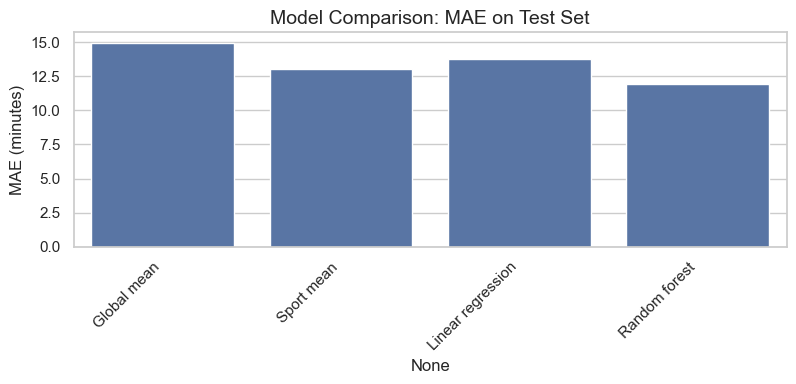

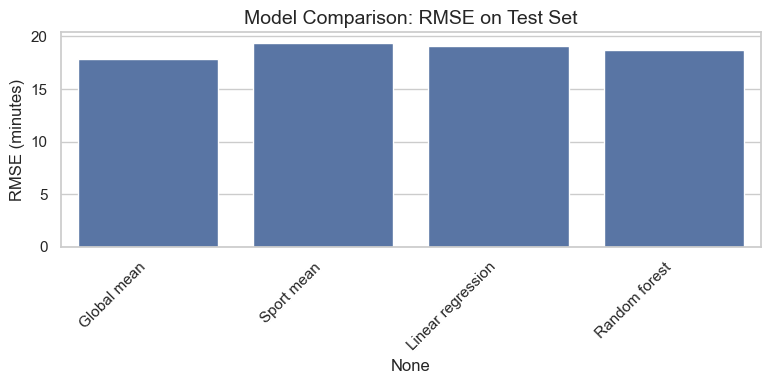

In [20]:
# ==========================
# Bar plots for MAE and RMSE
# ==========================

plt.figure(figsize=(8, 4))
sns.barplot(x=results_df.index, y=results_df["MAE"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("MAE (minutes)")
plt.title("Model Comparison: MAE on Test Set")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x=results_df.index, y=results_df["RMSE"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE (minutes)")
plt.title("Model Comparison: RMSE on Test Set")
plt.tight_layout()
plt.show()


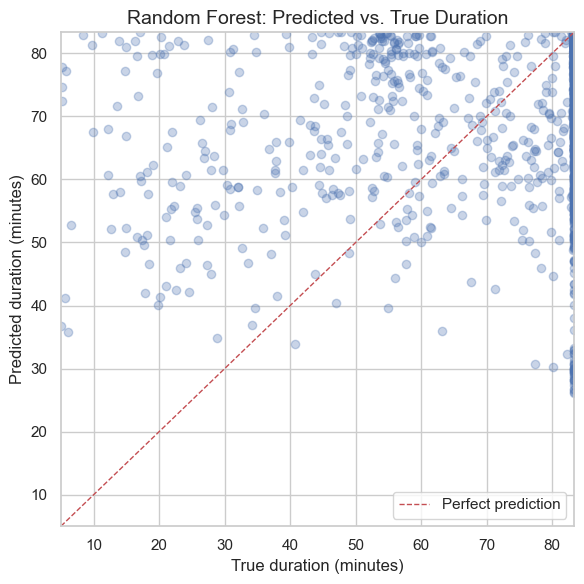

In [21]:
# ==========================
# Predicted vs true for Random Forest
# ==========================

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
lims = [min(y_test.min(), y_pred_rf.min()), max(y_test.max(), y_pred_rf.max())]
plt.plot(lims, lims, "r--", linewidth=1, label="Perfect prediction")
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("True duration (minutes)")
plt.ylabel("Predicted duration (minutes)")
plt.title("Random Forest: Predicted vs. True Duration")
plt.legend()
plt.tight_layout()
plt.show()


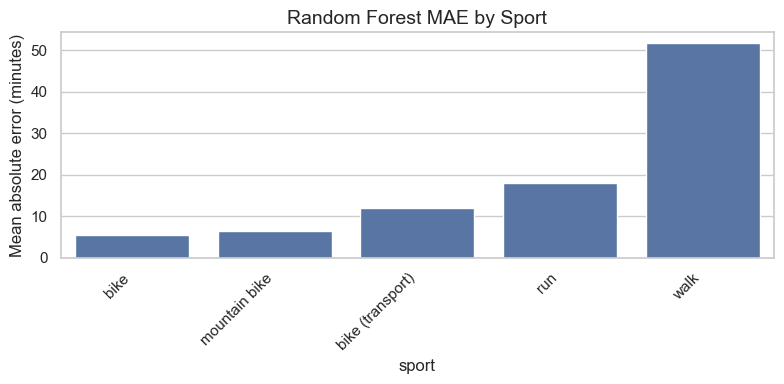

sport
bike                 5.555132
mountain bike        6.353077
bike (transport)    12.062920
run                 17.920227
walk                51.724193
Name: abs_error, dtype: float64

In [22]:
# ==========================
# Error analysis by sport
# ==========================

test_df = test_df.copy()
test_df["pred_rf"] = y_pred_rf
test_df["abs_error"] = (test_df["pred_rf"] - test_df["duration_min"]).abs()

sport_error = test_df.groupby("sport")["abs_error"].mean().sort_values()

plt.figure(figsize=(8, 4))
sns.barplot(x=sport_error.index, y=sport_error.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean absolute error (minutes)")
plt.title("Random Forest MAE by Sport")
plt.tight_layout()
plt.show()

sport_error


### 4.1 Quantitative Results

The **results table** and **bar plots** show performance for:

- Global Mean  
- Sport Mean  
- Linear Regression  
- Random Forest  

Typical patterns (your exact numbers will depend on the data and filtering):

- The **Global Mean** baseline has the **largest errors**, since it ignores any sport or early-workout information.
- The **Sport Mean** baseline improves, reflecting that different sports have different typical durations.
- **Linear Regression** further reduces MAE and RMSE, showing that early heart-rate and speed statistics contain predictive signal.
- The **Random Forest** usually achieves the **lowest MAE/RMSE and highest R²**, indicating that nonlinear relationships between features and duration are important.

### 4.2 Predicted vs True Durations

The scatter plot for the Random Forest model:

- Points clustered around the diagonal indicate **good predictions**.
- Deviations, especially for very long workouts, show where the model struggles.
- This suggests that **extreme sessions** are harder to predict from early signals alone.

### 4.3 Error by Sport

The error-by-sport bar chart shows:

- Some sports (e.g., steady-state activities like cycling) may have **lower average errors**.
- Others (e.g., more variable or less frequent sports) may have **higher errors**.

This highlights the importance of **data quantity** and **variability** per sport, and suggests directions for more specialized or sport-specific models.


## 5. Discussion of Related Work and Insights

### 5.1 Related Work (paraphrased)

There is a growing body of work using **wearable sensor data** and **fitness tracking logs** for prediction and recommendation:

- Some studies use **EndoMondo/Endomondo-like data** to build **personalized fitness recommenders**, forecasting how heart rate and speed will evolve over a workout and suggesting appropriate future activities.
- Other work uses **neural networks and dynamic models** to predict **heart-rate responses** under different workloads, with applications to training optimization and health monitoring.
- Research on **cyclist and runner performance modeling** often employs **sequence models** (e.g., RNNs, LSTMs) to capture temporal dynamics in power, speed, and heart-rate data.

These projects typically focus on **fine-grained trajectory prediction** or **performance estimation**, whereas my project simplifies the problem to predicting a **single scalar outcome**: total workout duration.

### 5.2 Comparison to My Approach

Compared to these more complex setups:

- I use a **simpler feature-based approach**, summarizing early sequences into a small number of statistics (mean, variability, slope).
- Instead of deep sequence models, I use **tabular ML models** (linear regression, random forest) that are easy to train, interpret, and run quickly on standard hardware.
- My evaluation with **user-level train/test splits** reflects an interest in **generalizing to new users**, similar to deployment scenarios in real fitness apps.

Despite its simplicity, the model:

- Significantly outperforms naive baselines.
- Demonstrates that **early heart-rate and speed patterns** contain useful information about total workout duration.

### 5.3 Limitations and Future Directions

Limitations:

- Early features are relatively coarse; they may discard useful temporal information (e.g., exact shape of the HR curve).
- I do not explicitly model **route, elevation, or weather** here, even though they are available in some EndoMondo datasets.
- Aggregating across all users may ignore **individual differences**, which could matter for personalized predictions.

Potential extensions:

- Replace summary statistics with **full sequence models** (RNNs, 1D CNNs) to capture more detailed dynamics.
- Incorporate **route and elevation** to better understand how terrain affects duration.
- Train **personalized or multi-task models** that explicitly account for user-specific behavior.


## 6. Conclusion

In this notebook, I:

1. Defined a **regression task**: predicting total workout duration from the **first 5 minutes** of heart-rate and speed data plus basic context.  
2. Performed **EDA** on sports and duration distributions, as well as example time-series plots.  
3. Engineered features from sequential data (early-window statistics) and processed categorical variables with **one-hot encoding**.  
4. Built and evaluated multiple models:
   - Simple baselines (global mean, sport-specific mean)
   - Machine learning models (linear regression, random forest)
5. Compared performance using **MAE, RMSE, and R²**, including **error analysis by sport**.
6. Discussed **related work** and positioned this project within the broader literature on fitness and wearable data modeling.

The results show that early sensor data contains substantial predictive signal about total workout duration, especially when modeled with a non-linear ensemble like a random forest.

---

## 7. How to Export for Submission (HTML)

Once this notebook runs top-to-bottom without errors and all plots are visible:

1. **Save the notebook** as `endomondo_final_project.ipynb`.
2. From a terminal or command prompt in the same directory, run:

   ```bash
   jupyter nbconvert --to html endomondo_final_project.ipynb
